In [8]:
# Cropping the images according to the bounding boxes in order to create a dataset of images with equal dimensions and size.

from PIL import Image
import numpy as np

def resize_image(image_name):
    # image_path =  os.path.join(DATA_DIR, image_name)
    im = Image.open(image_name)
    width,height = im.size

    new_width = min(width,height)
    new_height = min(width,height)

    left = int(np.ceil((width - new_width)/2))
    top = int(np.ceil((height - new_height)/2))
    right = int(np.ceil((width + new_width)/2))
    bottom = int(np.ceil((height + new_height)/2))

    im = im.crop((left, top, right, bottom))
    # im.save(os.path.join(OUTPUT_DIR, image_name))
    return im

im = Image.open("1.jpg")
im.show()
gen_im = resize_image(image_name="1.jpg")
gen_im.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 8/8 [11:08<00:00, 83.50s/it] 


Epoch: [1/20], loss_d: 2.3710, loss_g: 11.2553, real_score: 0.9352, fake_score: 0.8792


100%|██████████| 8/8 [08:44<00:00, 65.51s/it]


Epoch: [2/20], loss_d: 0.8859, loss_g: 5.0424, real_score: 0.7146, fake_score: 0.3273


100%|██████████| 8/8 [08:29<00:00, 63.73s/it]


Epoch: [3/20], loss_d: 0.5207, loss_g: 5.7498, real_score: 0.7049, fake_score: 0.0577


100%|██████████| 8/8 [08:32<00:00, 64.12s/it]


Epoch: [4/20], loss_d: 0.4398, loss_g: 5.9701, real_score: 0.8032, fake_score: 0.0755


100%|██████████| 8/8 [08:20<00:00, 62.59s/it]


Epoch: [5/20], loss_d: 0.5148, loss_g: 6.1137, real_score: 0.9615, fake_score: 0.3597


100%|██████████| 8/8 [08:25<00:00, 63.16s/it]


Epoch: [6/20], loss_d: 0.2956, loss_g: 4.5353, real_score: 0.9739, fake_score: 0.2314


100%|██████████| 8/8 [07:39<00:00, 57.44s/it]


Epoch: [7/20], loss_d: 0.0244, loss_g: 6.4654, real_score: 0.9877, fake_score: 0.0118


100%|██████████| 8/8 [08:33<00:00, 64.22s/it]


Epoch: [8/20], loss_d: 0.3626, loss_g: 7.1461, real_score: 0.7297, fake_score: 0.0016


100%|██████████| 8/8 [08:25<00:00, 63.16s/it]


Epoch: [9/20], loss_d: 1.0768, loss_g: 7.6633, real_score: 0.3858, fake_score: 0.0014


100%|██████████| 8/8 [07:55<00:00, 59.46s/it]


Epoch: [10/20], loss_d: 1.4159, loss_g: 2.0322, real_score: 0.7876, fake_score: 0.5971


100%|██████████| 8/8 [07:50<00:00, 58.85s/it]


Epoch: [11/20], loss_d: 0.9852, loss_g: 3.8388, real_score: 0.5471, fake_score: 0.2619


100%|██████████| 8/8 [07:52<00:00, 59.06s/it]


Epoch: [12/20], loss_d: 1.1073, loss_g: 2.1745, real_score: 0.5649, fake_score: 0.3800


100%|██████████| 8/8 [08:00<00:00, 60.08s/it]


Epoch: [13/20], loss_d: 1.4805, loss_g: 1.1036, real_score: 0.3518, fake_score: 0.2749


100%|██████████| 8/8 [07:55<00:00, 59.39s/it]


Epoch: [14/20], loss_d: 1.1242, loss_g: 1.8518, real_score: 0.5966, fake_score: 0.4305


100%|██████████| 8/8 [07:51<00:00, 58.94s/it]


Epoch: [15/20], loss_d: 1.6678, loss_g: 0.9435, real_score: 0.3402, fake_score: 0.3014


100%|██████████| 8/8 [07:56<00:00, 59.58s/it]


Epoch: [16/20], loss_d: 1.3030, loss_g: 1.1823, real_score: 0.4980, fake_score: 0.4191


100%|██████████| 8/8 [07:58<00:00, 59.82s/it]


Epoch: [17/20], loss_d: 1.8242, loss_g: 1.2803, real_score: 0.3567, fake_score: 0.4898


100%|██████████| 8/8 [07:54<00:00, 59.25s/it]


Epoch: [18/20], loss_d: 1.3606, loss_g: 2.1199, real_score: 0.5180, fake_score: 0.4231


100%|██████████| 8/8 [07:58<00:00, 59.82s/it]


Epoch: [19/20], loss_d: 1.5745, loss_g: 2.0549, real_score: 0.6474, fake_score: 0.6632


100%|██████████| 8/8 [07:59<00:00, 59.90s/it]


Epoch: [20/20], loss_d: 2.1656, loss_g: 0.6825, real_score: 0.2490, fake_score: 0.3698


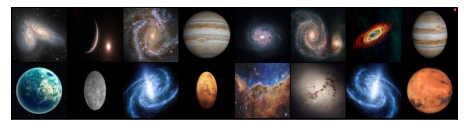

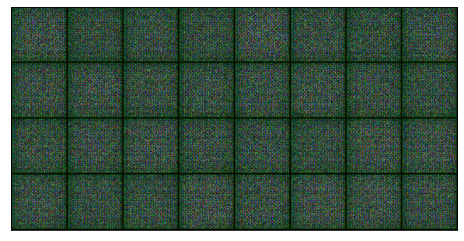

In [23]:
# Taking the image as input and generating a new image raw image.

import os
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

DATA_DIR = "./data/"

stats = (.5, .5, .5), (.5, .5, .5)

transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform_ds)


def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]


batch_size = 16

train_dl = DataLoader(ds, batch_size, shuffle=True,
                      num_workers=3, pin_memory=True)


def show_image(train_dl):
    for images, _ in train_dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(
            make_grid(denorm(images.detach()[:32]), nrow=8).permute(1, 2, 0))
        break


show_image(train_dl)


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)


device = get_device()

train_dl = DeviceDataLoader(train_dl, device)

discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

)

discriminator = to_device(discriminator, device)

latent_size = 128
generator = nn.Sequential(
    #in: 128 x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4,
                       stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()


)


generator = to_device(generator, device)


def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()

    return loss.item(), real_score, fake_score


def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward(),
    opt_g.step()

    return loss.item()


sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)


def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(
        sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()
                  [:32], nrow=8).permute(1, 2, 0))


fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)


def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),
                             lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(),
                             lr=lr_g, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(
                real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_d, loss_g, real_score, fake_score))

        save_sample(epoch+start_idx, fixed_latent, show=False)

    return losses_d, losses_g, real_scores, fake_scores


epochs = 20
lr_d = 10e-5
lr_g = 10e-4

history = [fit(epochs, lr_d, lr_g, start_idx=1)]